In [253]:
import numpy as np
import torch
import os
import cv2
import math
import datetime

from scipy.spatial.distance import cdist
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from models.superpoint import SuperPoint
from models.utils import read_image_wxl

train_path = "/home/wxl/Data/COCO2014/train2014/"
files = []
files += [train_path + f for f in os.listdir(train_path)]
sift = cv2.xfeatures2d.SIFT_create(nfeatures=1024)
matcher = cv2.BFMatcher_create(cv2.NORM_L1, crossCheck=False)

config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    }
}
device = 'cuda' if torch.cuda.is_available()  else 'cpu'
superpoint = SuperPoint(config.get('superpoint', {})).eval().to(device)

Loaded SuperPoint model


In [100]:
import matplotlib.pyplot as plt
import matplotlib
def make_matching_figure(
        img0, img1, mkpts0, mkpts1, color,
        kpts0=None, kpts1=None, text=[], dpi=75, path=None):
    # draw image pair
    assert mkpts0.shape[0] == mkpts1.shape[0], f'mkpts0: {mkpts0.shape[0]} v.s. mkpts1: {mkpts1.shape[0]}'
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), dpi=dpi)
    axes[0].imshow(img0, cmap='gray')
    axes[1].imshow(img1, cmap='gray')
    for i in range(2):   # clear all frames
        axes[i].get_yaxis().set_ticks([])
        axes[i].get_xaxis().set_ticks([])
        for spine in axes[i].spines.values():
            spine.set_visible(False)
    plt.tight_layout(pad=1)
    
    if kpts0 is not None:
        assert kpts1 is not None
        axes[0].scatter(kpts0[:, 0], kpts0[:, 1], c='w', s=2)
        axes[1].scatter(kpts1[:, 0], kpts1[:, 1], c='w', s=2)

    # draw matches
    if mkpts0.shape[0] != 0 and mkpts1.shape[0] != 0:
        fig.canvas.draw()
        transFigure = fig.transFigure.inverted()
        fkpts0 = transFigure.transform(axes[0].transData.transform(mkpts0))
        fkpts1 = transFigure.transform(axes[1].transData.transform(mkpts1))
        fig.lines = [matplotlib.lines.Line2D((fkpts0[i, 0], fkpts1[i, 0]),
                                            (fkpts0[i, 1], fkpts1[i, 1]),
                                            transform=fig.transFigure, c=color[i], linewidth=1)
                                        for i in range(len(mkpts0))]
        
        axes[0].scatter(mkpts0[:, 0], mkpts0[:, 1], c=color, s=4)
        axes[1].scatter(mkpts1[:, 0], mkpts1[:, 1], c=color, s=4)

    # put txts
    txt_color = 'k' if img0[:100, :200].mean() > 200 else 'w'
    fig.text(
        0.01, 0.99, '\n'.join(text), transform=fig.axes[0].transAxes,
        fontsize=15, va='top', ha='left', color=txt_color)

    # save or return figure
    if path:
        plt.savefig(str(path), bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        return fig

82783


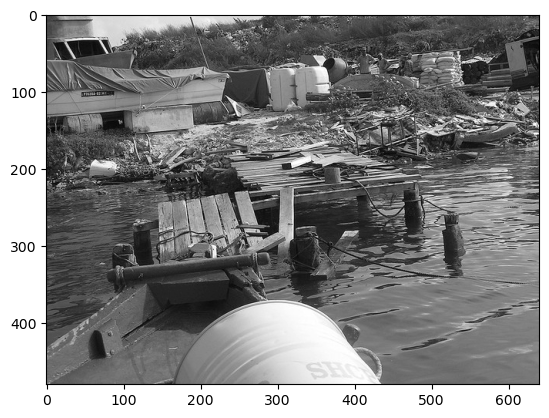

In [254]:
# %matplotlib
%matplotlib inline
file_name = files[0]
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plt.imshow(image, cmap='gray')
print(len(files))

## 测试inputdata

In [256]:
# limit the number of keypoints
kp1_num = min(1024, len(kp1))
kp2_num = min(1024, len(kp2))
kp1 = kp1[:kp1_num]
kp2 = kp2[:kp2_num]

kp1_np = np.array([(kp.pt[0], kp.pt[1]) for kp in kp1])
kp2_np = np.array([(kp.pt[0], kp.pt[1]) for kp in kp2])

# confidence of each key point
scores1_np = np.array([kp.response for kp in kp1]) 
scores2_np = np.array([kp.response for kp in kp2])

kp1_np = kp1_np[:kp1_num, :]
kp2_np = kp2_np[:kp2_num, :]
descs1 = descs1[:kp1_num, :]
descs2 = descs2[:kp2_num, :]

# obtain the matching matrix of the image pair
matched = matcher.match(descs1, descs2)
kp1_projected = cv2.perspectiveTransform(kp1_np.reshape((1, -1, 2)), M)[0, :, :] 
dists = cdist(kp1_projected, kp2_np)

min1 = np.argmin(dists, axis=0)
min2 = np.argmin(dists, axis=1)

min1v = np.min(dists, axis=1)
min1f = min2[min1v < 3]

xx = np.where(min2[min1] == np.arange(min1.shape[0]))[0]
matches = np.intersect1d(min1f, xx)

missing1 = np.setdiff1d(np.arange(kp1_np.shape[0]), min1[matches])
missing2 = np.setdiff1d(np.arange(kp2_np.shape[0]), matches)

MN = np.concatenate([min1[matches][np.newaxis, :], matches[np.newaxis, :]])
MN2 = np.concatenate([missing1[np.newaxis, :], (len(kp2)) * np.ones((1, len(missing1)), dtype=np.int64)])
MN3 = np.concatenate([(len(kp1)) * np.ones((1, len(missing2)), dtype=np.int64), missing2[np.newaxis, :]])
all_matches = np.concatenate([MN, MN2, MN3], axis=1)

kp1_np = kp1_np.reshape((1, -1, 2))
kp2_np = kp2_np.reshape((1, -1, 2))
descs1 = np.transpose(descs1 / 256.)
descs2 = np.transpose(descs2 / 256.)

# image = torch.from_numpy(image/255.).double()[None].cuda()
# warped = torch.from_numpy(warped/255.).double()[None].cuda()

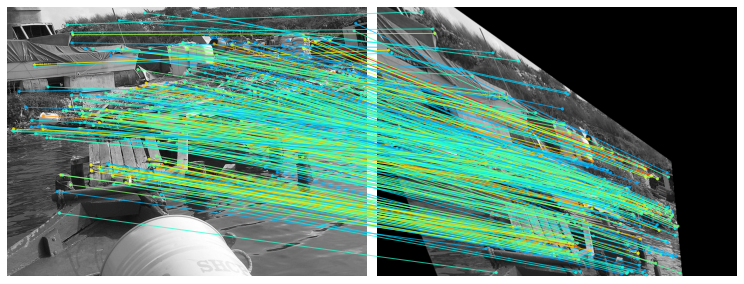

In [258]:
import matplotlib.cm as cm
color = cm.jet(scores1_np[MN[0]]*10, alpha=0.7)
match_kpts0 = kp1_np[0,MN[0]]                
match_kpts1 = kp2_np[0,MN[1]]
fig = make_matching_figure(
        image, warped, match_kpts0, match_kpts1, color,
        kpts0=None, kpts1=None, text=[], dpi=75, path=None)

In [259]:
from torch.autograd import Variable
match_kpts0 = torch.from_numpy(match_kpts0)
match_kpts1 = torch.from_numpy(match_kpts1)

In [324]:
x = torch.cat((match_kpts0,match_kpts1),dim=1).reshape((-1))  # n*4 ==> (n*4) 一维
imput = torch.zeros((200*4))
if x.shape[0]<imput.shape[0]:
    imput[:x.shape[0]] = x
else:
    imput = x[:imput.shape[0]]
imput.shape

torch.Size([800])

In [123]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        self.hidden1 = nn.Linear(200*4, 1024)
        self.hidden2 = nn.Linear(1024, 512)
        self.hidden3 = nn.Linear(512, 256)
        self.predict = nn.Linear(256,8)
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        return self.predict(x)
mlpreg = MLPregression()

In [332]:
output = mlpreg(imput.reshape(-1,800).float())
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(mlpreg.parameters(),lr=0.01)
M_tensor = torch.from_numpy(M.reshape(-1,9)[:,:8]).float()
torch.sum((M_tensor-output)**2)/8, loss_func(output, M_tensor)

(tensor(4487.8940, grad_fn=<DivBackward0>),
 tensor(4487.8940, grad_fn=<MseLossBackward0>))

In [338]:
import numpy as np
import torch
import os
import cv2
import math
import datetime

from scipy.spatial.distance import cdist
from torch.utils.data import Dataset

class SparseDataset(Dataset):
    """Sparse correspondences dataset."""

    def __init__(self, train_path, nfeatures):

        self.files = []
        self.files += [train_path + f for f in os.listdir(train_path)]

        self.nfeatures = nfeatures
        self.sift = cv2.xfeatures2d.SIFT_create(nfeatures=self.nfeatures)
        self.matcher = cv2.BFMatcher_create(cv2.NORM_L1, crossCheck=False)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
        sift = self.sift
        width, height = image.shape[:2]
        corners = np.array([[0, 0], [0, height], [width, 0], [width, height]], dtype=np.float32)
        warp = np.random.randint(-224, 224, size=(4, 2)).astype(np.float32)

        # get the corresponding warped image
        M = cv2.getPerspectiveTransform(corners, corners + warp)
        warped = cv2.warpPerspective(src=image, M=M, dsize=(image.shape[1], image.shape[0])) # return an image type
        
        # extract keypoints of the image pair using SIFT
        kp1, descs1 = sift.detectAndCompute(image, None)
        kp2, descs2 = sift.detectAndCompute(warped, None)

        # limit the number of keypoints
        kp1_num = min(self.nfeatures, len(kp1))
        kp2_num = min(self.nfeatures, len(kp2))
        kp1 = kp1[:kp1_num]
        kp2 = kp2[:kp2_num]

        kp1_np = np.array([(kp.pt[0], kp.pt[1]) for kp in kp1])
        kp2_np = np.array([(kp.pt[0], kp.pt[1]) for kp in kp2])

        # skip this image pair if no keypoints detected in image
        if len(kp1) < 1 or len(kp2) < 1:
            return torch.zeros((800), dtype=torch.float), torch.zeros((8), dtype=torch.float)

        # confidence of each key point
        scores1_np = np.array([kp.response for kp in kp1]) 
        scores2_np = np.array([kp.response for kp in kp2])

        kp1_np = kp1_np[:kp1_num, :]
        kp2_np = kp2_np[:kp2_num, :]
        descs1 = descs1[:kp1_num, :]
        descs2 = descs2[:kp2_num, :]

        # obtain the matching matrix of the image pair
        matched = self.matcher.match(descs1, descs2)
        kp1_projected = cv2.perspectiveTransform(kp1_np.reshape((1, -1, 2)), M)[0, :, :] 
        dists = cdist(kp1_projected, kp2_np)

        min1 = np.argmin(dists, axis=0)
        min2 = np.argmin(dists, axis=1)

        min1v = np.min(dists, axis=1)
        min1f = min2[min1v < 3]

        xx = np.where(min2[min1] == np.arange(min1.shape[0]))[0]
        matches = np.intersect1d(min1f, xx)
        MN = np.concatenate([min1[matches][np.newaxis, :], matches[np.newaxis, :]])

        kp1_np = kp1_np.reshape((1, -1, 2))
        kp2_np = kp2_np.reshape((1, -1, 2))

        match_kpts0 = kp1_np[0,MN[0]]                
        match_kpts1 = kp2_np[0,MN[1]]

        match_kpts0 = torch.from_numpy(match_kpts0)
        match_kpts1 = torch.from_numpy(match_kpts1)
        x = torch.cat((match_kpts0,match_kpts1),dim=1).reshape((-1))  # n*4 ==> (n*4) 一维
        imput = torch.zeros((200*4))
        if x.shape[0]<imput.shape[0]:
            imput[:x.shape[0]] = x
        else:
            imput = x[:imput.shape[0]]
        M_tensor = torch.from_numpy(M.reshape(9)[:8]).float()
        
        return  imput, M_tensor


In [339]:
train_set = SparseDataset("/home/wxl/Data/COCO2014/train2014/", 1024)
train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=False, batch_size=32, drop_last=True)
b_x,b_y = next(iter(train_loader))
b_x.shape,b_y.shape

(torch.Size([32, 800]), torch.Size([32, 8]))

In [340]:
train_loss_all = []
for epoch in range(1):
    train_loss = 0
    train_num = 0
    for step,(b_x,b_y) in enumerate(train_loader):
        output = mlpreg(b_x.float())
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*b_x.size(0)
        train_num += b_x.size(0)
        if step%20 == 0:
            print(step, train_loss/train_num)
    print(epoch, train_loss/80000)
    train_loss_all.append(train_loss/train_num)

0 nan
20 nan


KeyboardInterrupt: 

## superpoint

In [53]:
image0, inp0, scales0 = read_image_wxl( image, [-1], 0, True)
image1, inp1, scales1 = read_image_wxl( warped, [-1], 0, True)
data = {'image0': inp0, 'image1': inp1}
pred = {}
pred0 = superpoint({'image': data['image0']})
pred = {**pred, **{k+'0': v for k, v in pred0.items()}}

pred1 = superpoint({'image': data['image1']})
pred = {**pred, **{k+'1': v for k, v in pred1.items()}}
pred = {k: v[0].cpu().detach().numpy() for k, v in pred.items()}

/data/anaconda3/envs/wxl_vit/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [12]:
from torch.autograd import Variable
kpts0 = Variable(torch.stack(pred["keypoints0"]).cuda())
torch.reshape(kpts0, (1, -1, 2)).shape
desc0 = Variable(torch.stack(pred["descriptors0"]).cuda())
desc0.shape, desc0.transpose(0,1).shape

(torch.Size([1, 256, 865]), torch.Size([256, 1, 865]))

In [54]:
kpts0 = pred["keypoints0"]
kpts1 = pred["keypoints1"]

show_key_points = False
if show_key_points:
    kpts0 = np.round(kpts0).astype(int)
    kpts1 = np.round(kpts1).astype(int)
    white = (255, 255, 255)
    black = (0, 0, 0)
    for x, y in kpts0:
        cv2.circle(image0, (x, y), 2, black, -1, lineType=cv2.LINE_AA)
        cv2.circle(image0, (x, y), 1, white, -1, lineType=cv2.LINE_AA)
    for x, y in kpts1:
        cv2.circle(image1, (x, y), 2, black, -1, lineType=cv2.LINE_AA)
        cv2.circle(image1, (x, y), 1, white, -1, lineType=cv2.LINE_AA)
        
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(image0,cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(image1,cmap='gray')

In [55]:
kp0_projected = cv2.perspectiveTransform(kpts0.reshape((1, -1, 2)), M)[0, :, :] 
dists = cdist(kp0_projected, kpts1)
min1 = np.argmin(dists, axis=0)   # 与warped 中每个特征点距离最近的image特征点下标
min2 = np.argmin(dists, axis=1) 
min1v = np.min(dists, axis=1)        # 与image 中每个特征点距离最近warped的特征点 距离
min1f = min2[min1v < 3]                  # 筛选最近距离小于3的点
xx = np.where(min2[min1] == np.arange(min1.shape[0]))[0] # 判断是否相互都是距离最近的特征点
matches = np.intersect1d(min1f, xx) # 表示 warped 中成功匹配的特征点下标列表
# 输出距离矩阵的形状
print("Distance matrix shape:", dists.shape, min1.shape, min2.shape, min1v.shape, min1f.shape, matches.shape)

Distance matrix shape: (865, 512) (512,) (865,) (865,) (214,) (196,)


In [28]:
np.concatenate([min1[matches][np.newaxis, :], matches[np.newaxis, :]])[:,-3:]

array([[567, 498, 452],
       [504, 507, 511]])

In [56]:
missing1 = np.setdiff1d(np.arange(kpts0.shape[0]), min1[matches])
missing2 = np.setdiff1d(np.arange(kpts1.shape[0]), matches)

MN = np.concatenate([min1[matches][np.newaxis, :], matches[np.newaxis, :]])
MN2 = np.concatenate([missing1[np.newaxis, :], (len(kpts1)) * np.ones((1, len(missing1)), dtype=np.int64)])
MN3 = np.concatenate([(len(kpts0)) * np.ones((1, len(missing2)), dtype=np.int64), missing2[np.newaxis, :]])
all_matches = np.concatenate([MN, MN2, MN3], axis=1)
MN.shape,MN2.shape,MN3.shape,all_matches.shape

((2, 196), (2, 669), (2, 316), (2, 1181))

In [57]:
from load_data_wxl import SparseDatasetWxl
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    }
}

# load training data
# train_set = SparseDataset(opt.train_path, opt.max_keypoints)
train_set = SparseDatasetWxl(train_path, config)
train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=False, batch_size=1, drop_last=True)

Loaded SuperPoint model


In [58]:
for i, pred in enumerate(train_loader):
    # print(Variable(torch.stack(pred["scores0"]).cuda()).shape)
    for k in pred:
        if k != 'file_name' and k!='image0' and k!='image1':
            if type(pred[k]) == torch.Tensor:
                pred[k] = Variable(pred[k].cuda())
            else:
                pred[k] = Variable(torch.stack(pred[k]).cuda())
    break

In [59]:
all_matches = pred['all_matches'].permute(1,2,0) 
all_matches.shape

torch.Size([1, 1002, 2])

torch.Size([2, 1, 500])